Portfolio Optimization Project 


Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta, timezone
import yfinance as yf 
from scipy.optimize import minimize 

In [2]:
tickers = ['NLR','URA','VOO','QQQ','BMO','RSP']

In [3]:
end_date = datetime.today()


In [4]:
start_date = end_date - timedelta(days = 3 * 365)
print (start_date)

2022-01-31 12:07:49.977174


In [5]:
adj_close_df = pd.DataFrame()

In [6]:
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    adj_close_df[ticker] = data['Close']
print(adj_close_df)



[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NLR']: SSLError(MaxRetryError('HTTPSConnectionPool(host=\'fc.yahoo.com\', port=443): Max retries exceeded with url: / (Caused by SSLError(CertificateError("hostname \'fc.yahoo.com\' doesn\'t match either of \'secure.datavalet.io\', \'www.secure.datavalet.io\'")))'))
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['URA']: SSLError(MaxRetryError('HTTPSConnectionPool(host=\'fc.yahoo.com\', port=443): Max retries exceeded with url: / (Caused by SSLError(CertificateError("hostname \'fc.yahoo.com\' doesn\'t match either of \'secure.datavalet.io\', \'www.secure.datavalet.io\'")))'))
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['VOO']: SSLError(MaxRetryError('HTTPSConnectionPool(host=\'fc.yahoo.com\', port=443): Max retries exceeded with url: / (Caused by SSLError(CertificateError("hostname \'fc.yahoo.com\' doesn\'t ma

Empty DataFrame
Columns: [NLR, URA, VOO, QQQ, BMO, RSP]
Index: []


Calculate LogNormal Returns for each ticker
Calculate Daily returns 
LognORMAL RETURNS ARE ADDITIVE

takes one days price and shifts and diveds by the previous day price 

In [7]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

Drops any NA values so any future calcs dont get messed up 

In [8]:
log_returns = log_returns.dropna()

In [9]:
print(log_returns)

Empty DataFrame
Columns: [NLR, URA, VOO, QQQ, BMO, RSP]
Index: []


Calculate Covariance Matrix using Log Returns

we do times 252 to annualize this value and find the covariance and corelation between each of the securities in the portfolio

In [10]:
cov_matrix = log_returns.cov()*252
print(cov_matrix)

     NLR  URA  VOO  QQQ  BMO  RSP
NLR  NaN  NaN  NaN  NaN  NaN  NaN
URA  NaN  NaN  NaN  NaN  NaN  NaN
VOO  NaN  NaN  NaN  NaN  NaN  NaN
QQQ  NaN  NaN  NaN  NaN  NaN  NaN
BMO  NaN  NaN  NaN  NaN  NaN  NaN
RSP  NaN  NaN  NaN  NaN  NaN  NaN


/Users/sean/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/sean/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/sean/anaconda3/lib/python3.10/site-packages/pandas/core/frame.py:10474: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/Users/sean/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/sean/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


Calculate Portfolio Performance Metrics

calculate risk - calculates the variance, a Measure of risk associated with a porftolio of assets. It combines the volatility of assets in the portfolio 

STANDARD DEVIATION FIRST

. T transposes - an array that is 1 row high and 5 columns wide transpose it so that it is 5 columns high and 1 row wide 

the @ symbl means we are mulitplying two arrays together

we return the sq rt of variance because standard deviation is truly the square root of variance

In [11]:
def standard_deviation(weights, cov_matrix): ##inputs 
    variance = weights.T @ cov_matrix @ weights  ##what does the @ symbol do?
    return np.sqrt(variance)

calculate the expected return

Key assumption is expected returns are based on historical returns

In [12]:
def portfolio_return(weights, log_returns):
    return np.sum(log_returns.mean() * weights) * 252

Calculate Sharpe Ratio 
=
(Expected Return - risk free rate)/ Standard deviation 

In [13]:
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return(portfolio_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix) #risk premium divided by standard deviation

Get the risk free rate 

Fed reserve api pull

In [14]:
from fredapi import Fred

#replace with my api key and connect to fed
fred = Fred(api_key='051d5809ddca97caac87dd597a0ddc35')
ten_year_treasury = fred.get_series('GS10')/100##divide by 100 to get percentage

#set the risk free rate
risk_free_rate = ten_year_treasury.iloc[-1]
print(risk_free_rate)

URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: Hostname mismatch, certificate is not valid for 'api.stlouisfed.org'. (_ssl.c:997)>

define the function to minimize negative sharpe ratio 

In [212]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

set the constraints and bonds 

constraints make sure that the portfolio is the sum of the wieghts in the portfolio = 1
the bound is 0 lower and 5 upper 
0 means we cant go short or sell any assets - meaning we can only go long or purchase
5 means that we cant have more than 50% of our portfiolo in one single portfolio - this is for short time periods dont get tricked

In [213]:
consrtaints = ({'type':'eq', 'fun': lambda x: np.sum(x) - 1})
bounds =[(0,0.4) for i in range(len(tickers))]

set the initial weights 

dynamic function to set qual initial weights for all securities in portfolio 

In [214]:
initial_weights = np.array([1/len(tickers)] * len(tickers))
print(initial_weights)

[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]


optimize the weights to maxmize sharpe ratio 

SLQP stands for least square quadratic programming, a Numerical Optimaization technique for suitable for solving non linear optimzation problems with constarints

In [215]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=consrtaints, bounds=bounds)

get optimal weights 

.x is a way for us to acces those results 

In [216]:
optimal_weights = optimized_results.x

Analyze the optimal Portfolio 
display analytics of porfolio 

In [217]:
print("Optimal_weights")
for ticker, weight in zip(tickers, optimal_weights):
    print(f'{ticker}: {weight*100:.4f}%')

print()
optimal_portfolio_return = portfolio_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f'Expected annual return: {optimal_portfolio_return:.4f}')
print(f'Expected annual volatility: {optimal_portfolio_volatility:.4f}')
print(f'Sharpe ratio: {optimal_sharpe_ratio:.4f}')

Optimal_weights
NLR: 40.0000%
URA: 0.0000%
VOO: 40.0000%
QQQ: 20.0000%
BMO: 0.0000%
RSP: 0.0000%

Expected annual return: 0.1694
Expected annual volatility: 0.1869
Sharpe ratio: 0.6714


Display in a graph 

In [218]:
def simulate_random_portfolios(num_portfolios, log_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(tickers))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_return_value = portfolio_return(weights, log_returns)
        portfolio_volatility = standard_deviation(weights, cov_matrix)
        sharpe_ratio_value = (portfolio_return_value - risk_free_rate) / portfolio_volatility
        results[0,i] = portfolio_return_value
        results[1,i] = portfolio_volatility
        results[2,i] = sharpe_ratio_value
    return results, weights_record  

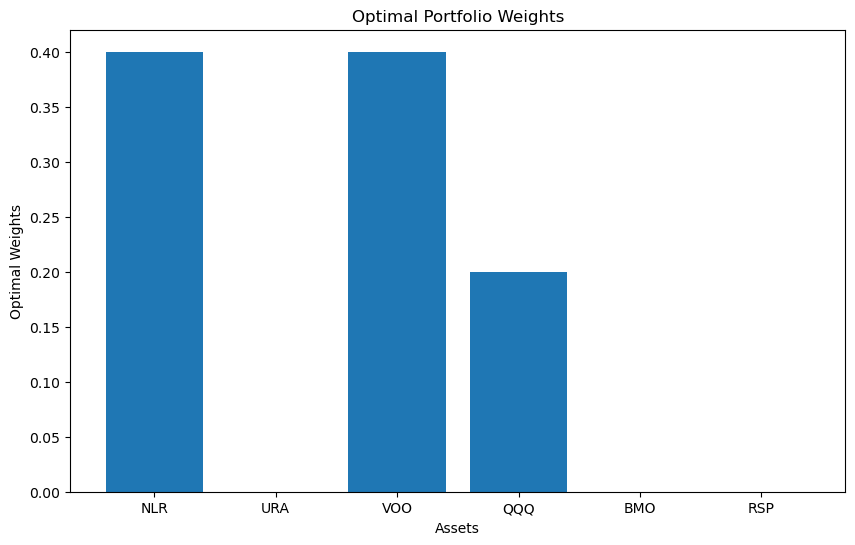

In [219]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(tickers, optimal_weights)


plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')


plt.show()